In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

# Covid data

In [ ]:
def load_individual_timeseries(name):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    df = pd.read_csv(url, 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df

def load_data(drop_states=False, p_crit=.05, filter_n_days_100=None):
    df = load_individual_timeseries('confirmed')
    df = df.rename(columns={'cases': 'confirmed'})
    if drop_states:
        # Drop states for simplicity
        df = df.loc[df.state.isnull()]
        
    # Estimated critical cases
    df = df.assign(critical_estimate=df.confirmed*p_crit)

    # Compute days relative to when 100 confirmed cases was crossed
    df.loc[:, 'days_since_100'] = np.nan
    for country in df.country.unique():
        if not df.loc[(df.country == country), 'state'].isnull().all():
            for state in df.loc[(df.country == country), 'state'].unique():
                df.loc[(df.country == country) & (df.state == state), 'days_since_100'] = \
                    np.arange(-len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed < 100)]), 
                              len(df.loc[(df.country == country) & (df.state == state) & (df.confirmed >= 100)]))
        else:
            df.loc[(df.country == country), 'days_since_100'] = \
                np.arange(-len(df.loc[(df.country == country) & (df.confirmed < 100)]), 
                          len(df.loc[(df.country == country) & (df.confirmed >= 100)]))

    # Add recovered cases
#     df_recovered = load_individual_timeseries('Recovered')
#     df_r = df_recovered.set_index(['country', 'state'], append=True)[['cases']]
#     df_r.columns = ['recovered']

    # Add deaths
    df_deaths = load_individual_timeseries('deaths')
    df_d = df_deaths.set_index(['country', 'state'], append=True)[['cases']]
    df_d.columns = ['deaths']

    df = (df.set_index(['country', 'state'], append=True)
#             .join(df_r)
            .join(df_d)
            .reset_index(['country', 'state'])
    )
    
    if filter_n_days_100 is not None:
        # Select countries for which we have at least some information
        countries = pd.Series(df.loc[df.days_since_100 >= filter_n_days_100].country.unique())
        df = df.loc[lambda x: x.country.isin(countries)]

    return df

In [ ]:
df_confirmed = load_individual_timeseries('confirmed')
#df_death = load_individual_timeseries('deaths')
df_recovered = load_individual_timeseries('recovered')

In [ ]:
df_confirmed = df_confirmed[~df_confirmed['country'].str.contains(' \(total\)')].drop(['state', 'type'], axis=1, ).reset_index()
df_recovered = df_recovered[~df_recovered['country'].str.contains(' \(total\)')].drop(['state', 'type'], axis=1, ).reset_index()

In [ ]:
df_confirmed = df_confirmed.rename({'cases':'CONFIRMED_CASES'}, axis=1)
df_recovered = df_recovered.rename({'cases':'RECOVERED_CASES'}, axis=1)

In [ ]:
df_recovered = df_recovered.merge(df_confirmed, on=['date','country'], how='left')

In [ ]:
#Calculate covid recovery rate
df_recovered['RECOVERY_RATE'] = (df_recovered['RECOVERED_CASES'] / df_recovered['CONFIRMED_CASES'] ) * 100

In [ ]:
#Remove infinity values
df_recovered = df_recovered.replace([np.inf, -np.inf], np.nan)

In [ ]:
df_recovered['RECOVERY_RATE'] = df_recovered['RECOVERY_RATE'].fillna(0)

In [ ]:
df_recovered['Month'] = pd.DatetimeIndex(df_recovered['date']).month
df_recovered['Year'] = pd.DatetimeIndex(df_recovered['date']).year
df_recovered = df_recovered.drop(columns='date', axis =1)
df_recovered.head()

,country,RECOVERED_CASES,CONFIRMED_CASES,RECOVERY_RATE,Month,Year
0,Afghanistan,0,0,0.0,1,2020
1,Afghanistan,0,0,0.0,1,2020
2,Afghanistan,0,0,0.0,1,2020
3,Afghanistan,0,0,0.0,1,2020
4,Afghanistan,0,0,0.0,1,2020


In [ ]:
#Select covid cases month wise split for 2020
df_recent = df_recovered[df_recovered['Year'] == 2020]
df_recent.head()

,country,RECOVERED_CASES,CONFIRMED_CASES,RECOVERY_RATE,Month,Year
0,Afghanistan,0,0,0.0,1,2020
1,Afghanistan,0,0,0.0,1,2020
2,Afghanistan,0,0,0.0,1,2020
3,Afghanistan,0,0,0.0,1,2020
4,Afghanistan,0,0,0.0,1,2020


In [ ]:
df_recent = df_recent.drop(columns=['RECOVERED_CASES','CONFIRMED_CASES'], axis =1)

In [ ]:
df_recent.head()

,country,RECOVERY_RATE,Month,Year
0,Afghanistan,0.0,1,2020
1,Afghanistan,0.0,1,2020
2,Afghanistan,0.0,1,2020
3,Afghanistan,0.0,1,2020
4,Afghanistan,0.0,1,2020


In [ ]:
#Group data by country and period
df_recent = df_recent.groupby(['country','Month','Year']).agg({'RECOVERY_RATE': 'mean'}).reset_index()
df_recent

,country,Month,Year,RECOVERY_RATE
0,Afghanistan,1,2020,0.000000
1,Afghanistan,2,2020,0.000000
2,Afghanistan,3,2020,1.559035
3,Afghanistan,4,2020,8.741900
4,Afghanistan,5,2020,11.477166
...,...,...,...,...
2311,Zimbabwe,8,2020,54.768123
2312,Zimbabwe,9,2020,77.169833
2313,Zimbabwe,10,2020,89.579339
2314,Zimbabwe,11,2020,91.151584


In [ ]:
df_recent.columns = ['COUNTRY', 'MONTH', 'YEAR', 'RECOVERY_RATE']
df_recent.head()

,COUNTRY,MONTH,YEAR,RECOVERY_RATE
0,Afghanistan,1,2020,0.000000
1,Afghanistan,2,2020,0.000000
2,Afghanistan,3,2020,1.559035
3,Afghanistan,4,2020,8.741900
4,Afghanistan,5,2020,11.477166


In [ ]:
df_recent = df_recent.round()

In [ ]:
for i, row in df_recent.iterrows():
    if df_recent.loc[i,'COUNTRY']=='Taiwan*':
      df_recent.at[i,'COUNTRY'] = 'Taiwan (China)'
    if df_recent.loc[i,'COUNTRY']=='US':
      df_recent.at[i,'COUNTRY'] = 'USA'
    if df_recent.loc[i,'COUNTRY']=='Korea, South':
      df_recent.at[i,'COUNTRY'] = 'Korea (South)'
    if df_recent.loc[i,'COUNTRY']=='China':
      df_recent.at[i,'COUNTRY'] = 'China, P.R.'
    if df_recent.loc[i,'COUNTRY']=='Czechia':
      df_recent.at[i,'COUNTRY'] = 'Czech Republic'

In [ ]:
#Final covid recovery rate data for country in 2020 month wise split
df_recent.head()

,COUNTRY,MONTH,YEAR,RECOVERY_RATE
0,Afghanistan,1,2020,0.0
1,Afghanistan,2,2020,0.0
2,Afghanistan,3,2020,2.0
3,Afghanistan,4,2020,9.0
4,Afghanistan,5,2020,11.0


# Booking data

In [ ]:
df = pd.read_excel("/content/booking_ENC_data_2019.xlsx")

In [ ]:
df.head()

,BOOKING_ID,BOOKING_STATUS_NAME,F_KEY,BOOKING_DATE,HOTEL_ARRIVAL_DATE,HOTEL_DEPARTURE_DATE,HOTEL_CHAIN_NAME,HOTEL_NAME,HOTEL_CATEGORY_NAME,HOTEL_ID,HOTEL_COUNTRY_NAME,HOTEL_CITY_NAME,BOOKING_ORIGIN_COUNTRY_NAME,TRAVELLER_ID_ENC,TRAVELLER2_ID_ENC,PRICE_LIMIT_REASON,BOOKING_TYPE,BOOKING_PRODUCT_TYPE_NAME,ORIGINAL_BOOKING_SOURCE_GROUP_NAME,ORIGINAL_BOOKING_SOURCE_NAME,PAYMENT_GUARANTEE_NAME,AMOUNT_TURNOVER_EUR,NUMBER_BOOKED_ROOMNIGHTS
0,248140012,booked,16525,2020-03-06,2020-03-10,2020-03-11,individual,Porth Avallen,***,152785,United Kingdom,"Saint Austell, Cornwall (England)",United Kingdom,c1beeaf361,f8fd6e3b23,NaN,Business,INDIVIDUAL BOOKING,GDS,Sabre GDS,Guaranteed reservation,74.799,1
1,244119532,booked,15488,2020-01-10,2020-01-20,2020-01-21,individual,Ecoinn,***,437274,Germany,Esslingen am Neckar (Baden-Württemberg),Germany,ec955ef5e7,f8fd6e3b23,NaN,Business,INDIVIDUAL BOOKING,OBE,Concur HRS,Guaranteed reservation,93.100,1
2,254834709,booked,8734,2020-12-07,2020-12-08,2020-12-10,individual,Versant hotel SPA,****,588706,Poland,Dzierżoniów (Dolnośląskie),Poland,53805fa735,f8fd6e3b23,NaN,Business,INDIVIDUAL BOOKING,Web,WWW,Guaranteed reservation,114.332,2
3,249088120,booked,30876,2020-03-28,2020-03-29,2020-04-02,Kempinski Hotels & Resorts,Kempinski Hotel Changsha,*****,685304,"China, P.R.",Changsha (Hunan Province),"China, P.R.",d93d18d3cf,f8fd6e3b23,NaN,Business,INDIVIDUAL BOOKING,SOAP,Alibaba Group,Guaranteed reservation,257.340,4
4,245401235,booked,8855,2020-01-27,2020-01-29,2020-01-30,Starhotels,Starhotels Anderson,****,60238,Italy,Milano (Lombardia),Italy,19bcd45f98,f8fd6e3b23,NaN,Business,INDIVIDUAL BOOKING,OBE,Biztravel,Guaranteed reservation,145.000,1


In [ ]:
hrc_drop_columns = ['F_KEY','HOTEL_DEPARTURE_DATE','HOTEL_CHAIN_NAME','HOTEL_NAME','HOTEL_ID','TRAVELLER_ID_ENC','TRAVELLER2_ID_ENC','PRICE_LIMIT_REASON','BOOKING_PRODUCT_TYPE_NAME','ORIGINAL_BOOKING_SOURCE_GROUP_NAME','ORIGINAL_BOOKING_SOURCE_NAME','PAYMENT_GUARANTEE_NAME','AMOUNT_TURNOVER_EUR']
df = df.drop(columns=hrc_drop_columns, axis =1)

In [ ]:
hrc_drop_columns_add = ['HOTEL_CATEGORY_NAME','HOTEL_CITY_NAME','NUMBER_BOOKED_ROOMNIGHTS','BOOKING_ORIGIN_COUNTRY_NAME']
df = df.drop(columns=hrc_drop_columns_add, axis =1)

In [ ]:
#Booking data from HRS only for booked corporate travels
booked_df = df[(df['BOOKING_STATUS_NAME'] == 'booked') & (df['BOOKING_TYPE'] == 'Business')]
booked_df['ARRIVAL_AFTER'] = (booked_df['HOTEL_ARRIVAL_DATE'] - booked_df['BOOKING_DATE']).dt.days
booked_df = booked_df.drop(columns=['BOOKING_STATUS_NAME','BOOKING_TYPE','HOTEL_ARRIVAL_DATE'], axis =1)
booked_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,BOOKING_ID,BOOKING_DATE,HOTEL_COUNTRY_NAME,ARRIVAL_AFTER
0,248140012,2020-03-06,United Kingdom,4
1,244119532,2020-01-10,Germany,10
2,254834709,2020-12-07,Poland,1
3,249088120,2020-03-28,"China, P.R.",1
4,245401235,2020-01-27,Italy,2


In [ ]:
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'Cape Verde']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'French Guiana']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'Guadeloupe']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'Martinique']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'N.A.']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'Puerto Rico']
booked_df = booked_df[booked_df.HOTEL_COUNTRY_NAME != 'Turks and Caicos Islands']

In [ ]:
#Booking details for 2020 and arrival gap not more than a month
booked_df['BOOKING_YEAR'] = pd.DatetimeIndex(booked_df['BOOKING_DATE']).year
booked_df['BOOKING_MONTH'] = pd.DatetimeIndex(booked_df['BOOKING_DATE']).month
booked_df = booked_df[(booked_df.BOOKING_YEAR != 2019) & (booked_df['ARRIVAL_AFTER'] <= 30)]
booked_df = booked_df.drop(columns=['BOOKING_DATE','ARRIVAL_AFTER'], axis =1)

In [ ]:
booked_df.head()

,BOOKING_ID,HOTEL_COUNTRY_NAME,BOOKING_YEAR,BOOKING_MONTH
0,248140012,United Kingdom,2020,3
1,244119532,Germany,2020,1
2,254834709,Poland,2020,12
3,249088120,"China, P.R.",2020,3
4,245401235,Italy,2020,1


In [ ]:
count_df = booked_df.groupby(['HOTEL_COUNTRY_NAME','BOOKING_YEAR','BOOKING_MONTH']).agg({'BOOKING_ID': 'count'}).reset_index()

In [ ]:
count_df.columns = ['COUNTRY','YEAR','MONTH','NO_OF_BOOKINGS']

In [ ]:
#Merge booking data and covid data for 2020, month and country wise split
count_df = count_df.merge(df_recent, on=['COUNTRY','MONTH','YEAR'], how='left')

In [ ]:
count_df['RECOVERY_RATE'] = count_df.RECOVERY_RATE.astype(int)

In [ ]:
count_df.head()

,COUNTRY,YEAR,MONTH,NO_OF_BOOKINGS,RECOVERY_RATE
0,Algeria,2020,3,1,13
1,Argentina,2020,1,2,0
2,Argentina,2020,2,1,0
3,Argentina,2020,3,1,5
4,Australia,2020,1,8,1


# Cat Boost classifier

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
count_df

,COUNTRY,YEAR,MONTH,NO_OF_BOOKINGS,RECOVERY_RATE
0,Algeria,2020,3,1,13
1,Argentina,2020,1,2,0
2,Argentina,2020,2,1,0
3,Argentina,2020,3,1,5
4,Australia,2020,1,8,1
...,...,...,...,...,...
409,United Kingdom,2020,9,17,895
410,United Kingdom,2020,10,9,1104
411,United Kingdom,2020,11,6,1256
412,United Kingdom,2020,12,5,880


In [ ]:
#Output label - country
X = count_df.drop(columns=['COUNTRY'], axis=1).copy()
y = count_df['COUNTRY'].copy()

label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
X.shape, y.shape

((414, 4), (414,))

In [ ]:
label_enc.classes_

array(['Algeria', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei',
       'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China, P.R.',
       'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Czech Republic',
       'Denmark', 'Dominican Republic', 'Egypt', 'Estonia', 'Finland',
       'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'India',
       'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan',
       'Kenya', 'Korea (South)', 'Kosovo', 'Kuwait', 'Latvia',
       'Lithuania', 'Luxembourg', 'Madagascar', 'Malaysia', 'Malta',
       'Mexico', 'Morocco', 'Nepal', 'Netherlands', 'New Zealand',
       'Norway', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal',
       'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'Spain',
       'Sweden', 'Switzerland', 'Taiwan (China)', 'Thailand', 'Tunisia',
       'Turkey', 'USA', 'Uganda', 'Ukraine

In [ ]:
#Test and Train data split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((331, 4), (83, 4))

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer, ndcg_score
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.

    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.

    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
def grid_search(model, grid_param):
    print("Obtaining Best Model for {}".format(model.__class__.__name__))
    grid_search = GridSearchCV(model, grid_param, cv=kf, scoring=ndcg_scorer, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)
    
    cvres = grid_search.cv_results_
    print("Results for each run of {}...".format(model.__class__.__name__))
    for train_mean_score, test_mean_score, params in zip(cvres["mean_train_score"], cvres["mean_test_score"], cvres["params"]):
        print(train_mean_score, test_mean_score, params)
        
    return grid_search.best_estimator_

In [ ]:
results = []
    
def performance_measures(model, store_results=True):
    train_ndcg = cross_val_score(model, X_train, y_train, scoring=ndcg_scorer, cv=kf, n_jobs=-1)
    test_ndcg = cross_val_score(model, X_test_transformed, y_test, scoring=ndcg_scorer, cv=kf, n_jobs=-1)
    print("Mean Train NDGC: {}\nMean Test NDGC: {}".format(train_ndcg.mean(), test_ndcg.mean()))

In [ ]:
def plot_feature_importance(feature_columns, importance_values,top_n_features=0):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)

    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

catboost_grid_params = [{'iterations':[500], 'depth':[4, 6],}]

catboost_clf = CatBoostClassifier(task_type="GPU", loss_function='MultiClass', bagging_temperature=0.3, 
                                  cat_features=[1, 2, 3], random_state=42, verbose=0)

grid_search_results = catboost_clf.grid_search(catboost_grid_params,
            X_train,
            y_train,
            cv=5,
            partition_random_seed=42,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=0,
            plot=False)

bestTest = 3.992474001
bestIteration = 224
bestTest = 4.09466826
bestIteration = 242


In [ ]:
grid_search_results['params']

{'depth': 4, 'iterations': 500}

In [ ]:
catboost_clf.is_fitted()

True

In [ ]:
catboost_clf.feature_importances_

array([ 0.        , 31.19382991, 35.10337077, 33.70279932])

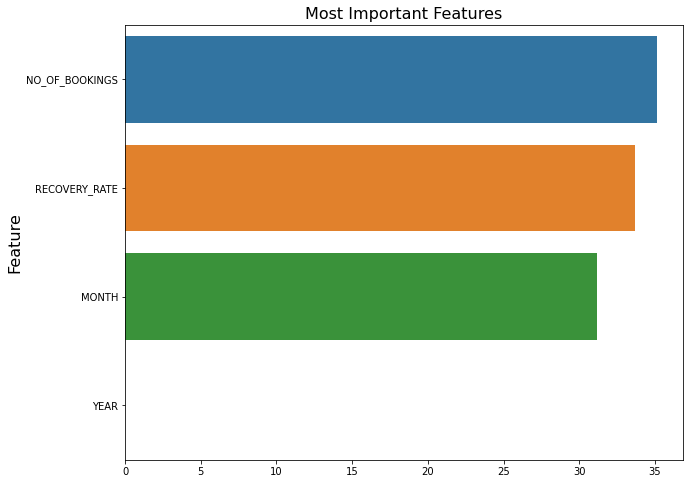

In [ ]:
import seaborn as sns
plot_feature_importance(['YEAR', 'MONTH', 'NO_OF_BOOKINGS','RECOVERY_RATE'], catboost_clf.feature_importances_)

In [ ]:
predicted_country = catboost_clf.predict(X)
predicted_country = label_enc.inverse_transform(predicted_country)
count_df['PREDICTED_COUNTRY'] = predicted_country

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


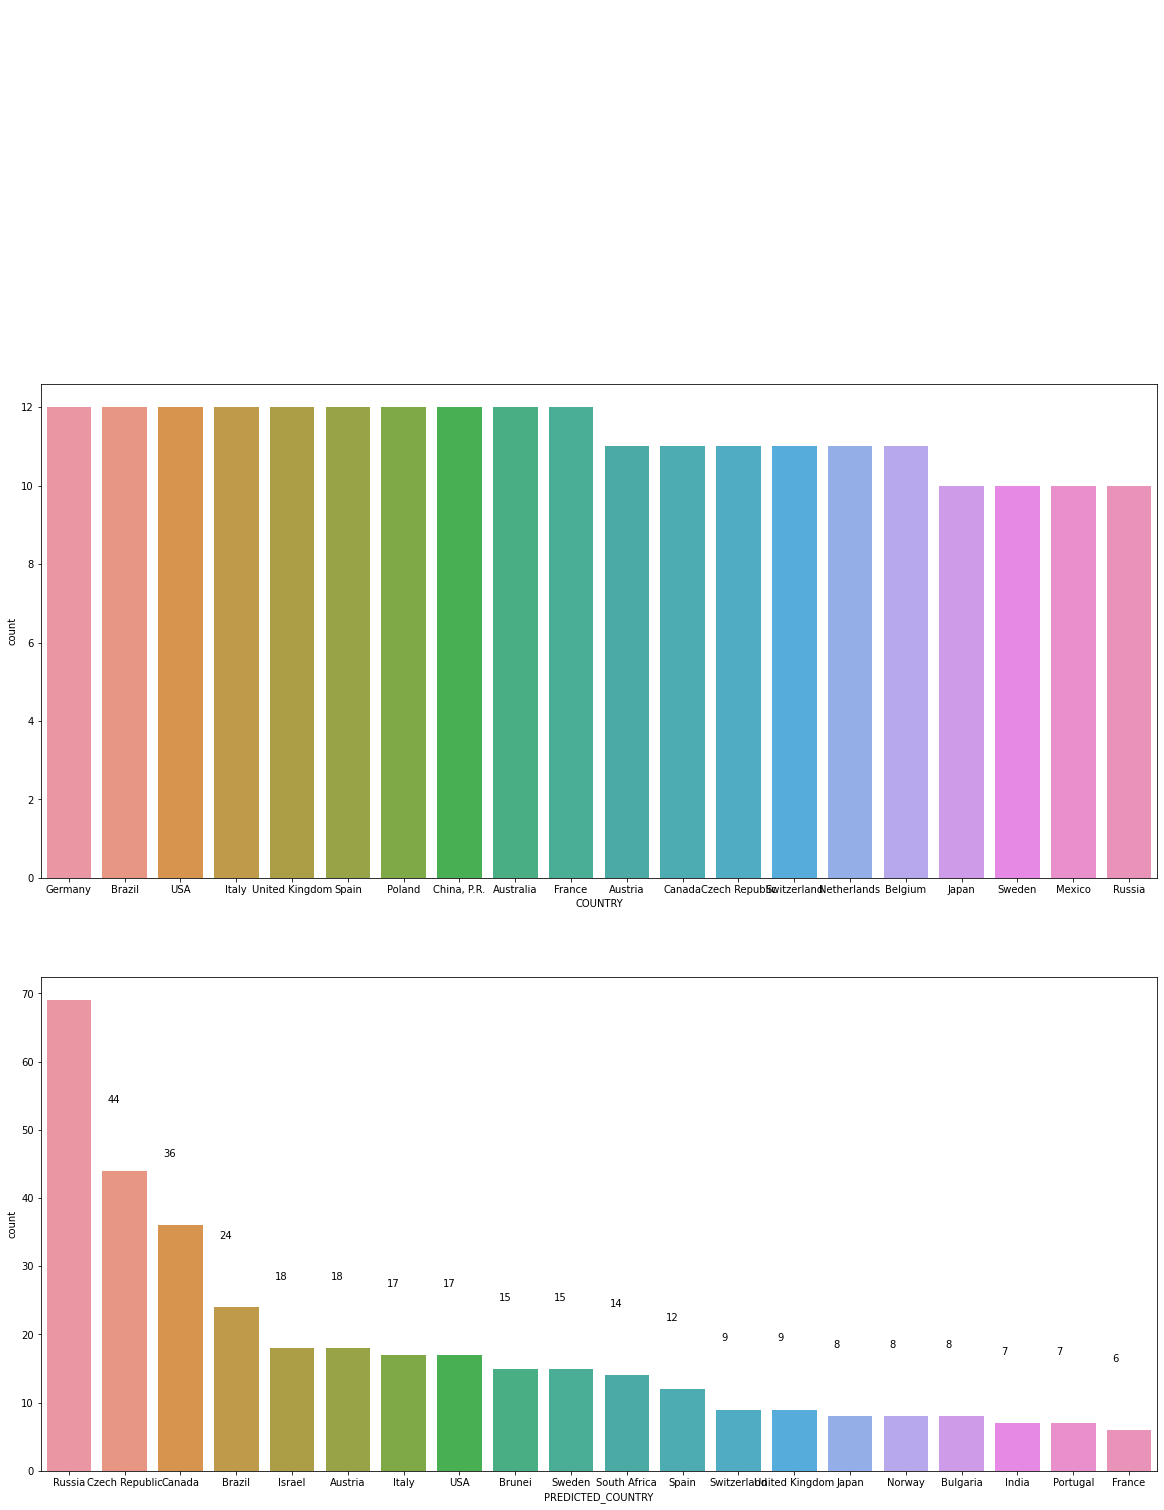

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
ax = sns.countplot(x='COUNTRY', data=count_df, order=count_df.COUNTRY.value_counts(ascending=False).iloc[:20].index)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
plt.subplot(2, 1, 2)
ax = sns.countplot(x='PREDICTED_COUNTRY', data=count_df, order=count_df.PREDICTED_COUNTRY.value_counts(ascending=False).iloc[:20].index)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))

###Countries predicted more often in 2020

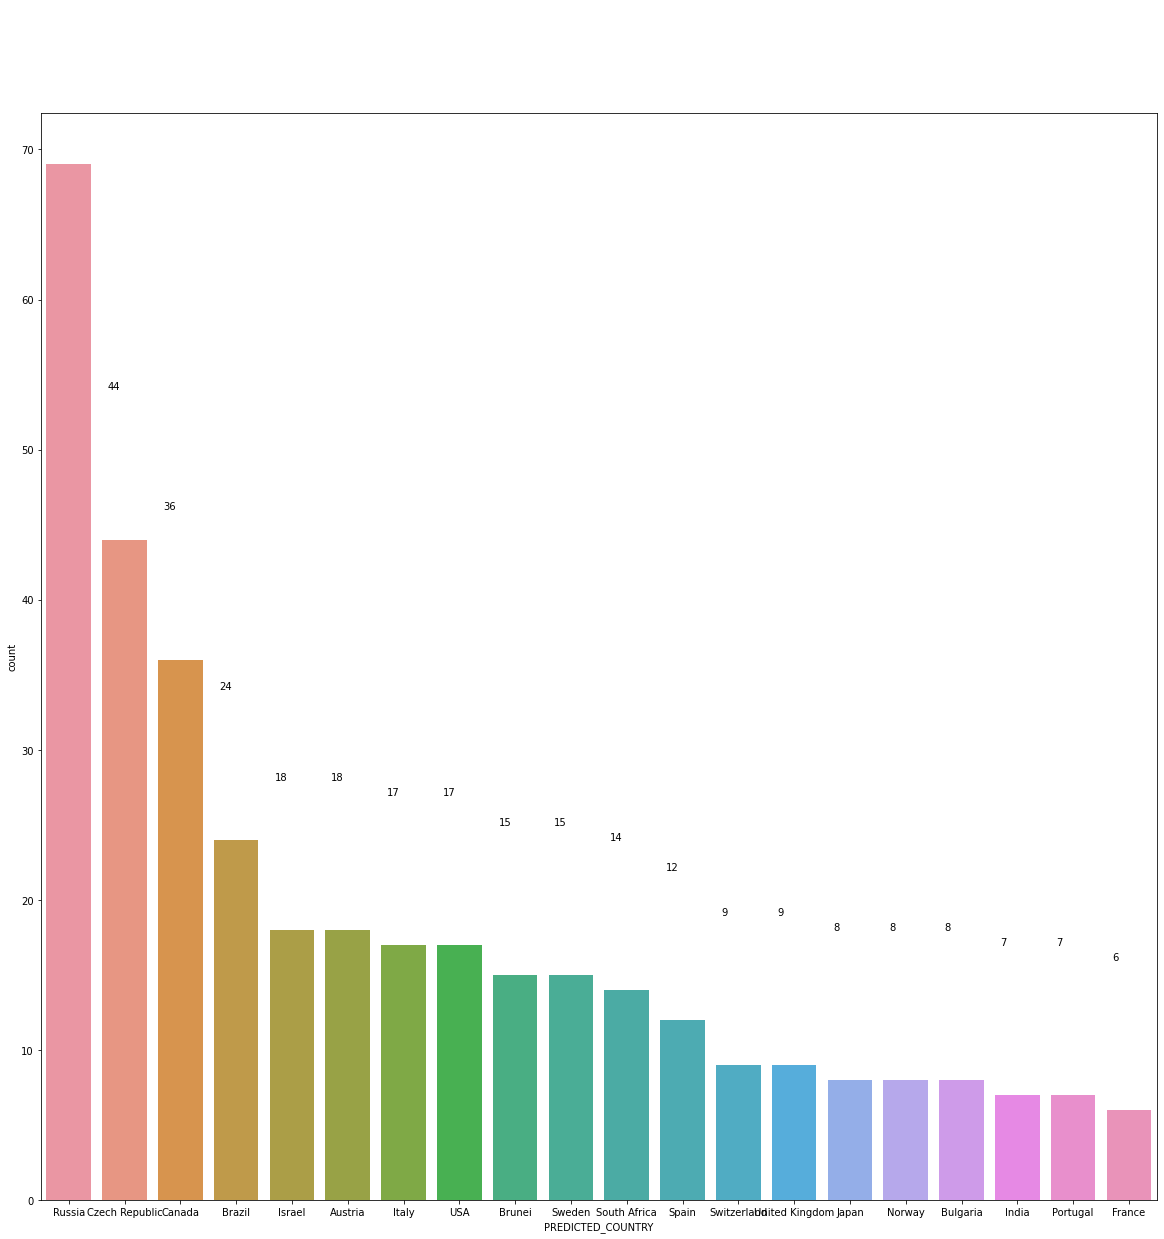

In [ ]:
plt.figure(figsize=(20, 20))
ax = sns.countplot(x='PREDICTED_COUNTRY', data=count_df, order=count_df.PREDICTED_COUNTRY.value_counts(ascending=False).iloc[:20].index)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))

###Countries with maximum recovery rate in 2020

In [ ]:
plot_df = count_df.drop(columns=['YEAR','MONTH'], axis =1)
plot_df = count_df.groupby(['COUNTRY']).agg({'RECOVERY_RATE': 'sum', 'NO_OF_BOOKINGS':'sum'}).reset_index()
plot_df

,COUNTRY,RECOVERY_RATE,NO_OF_BOOKINGS
0,Algeria,13,1
1,Argentina,5,4
2,Australia,8737,51
3,Austria,671,166
4,Belgium,188,64
...,...,...,...
74,Uganda,0,1
75,Ukraine,43,3
76,United Arab Emirates,127,8
77,United Kingdom,7541,227


In [ ]:
rate_df = plot_df[plot_df['RECOVERY_RATE'] > 390]
rate_df

,COUNTRY,RECOVERY_RATE,NO_OF_BOOKINGS
2,Australia,8737,51
3,Austria,671,166
7,Brazil,621,253
11,Canada,2789517,42
13,"China, P.R.",91699,1914
18,Czech Republic,527,69
19,Denmark,105167,34
24,France,255481,754
26,Germany,755,5221
29,India,480,75


In [ ]:
book_df = plot_df[plot_df['NO_OF_BOOKINGS'] > 33 ]

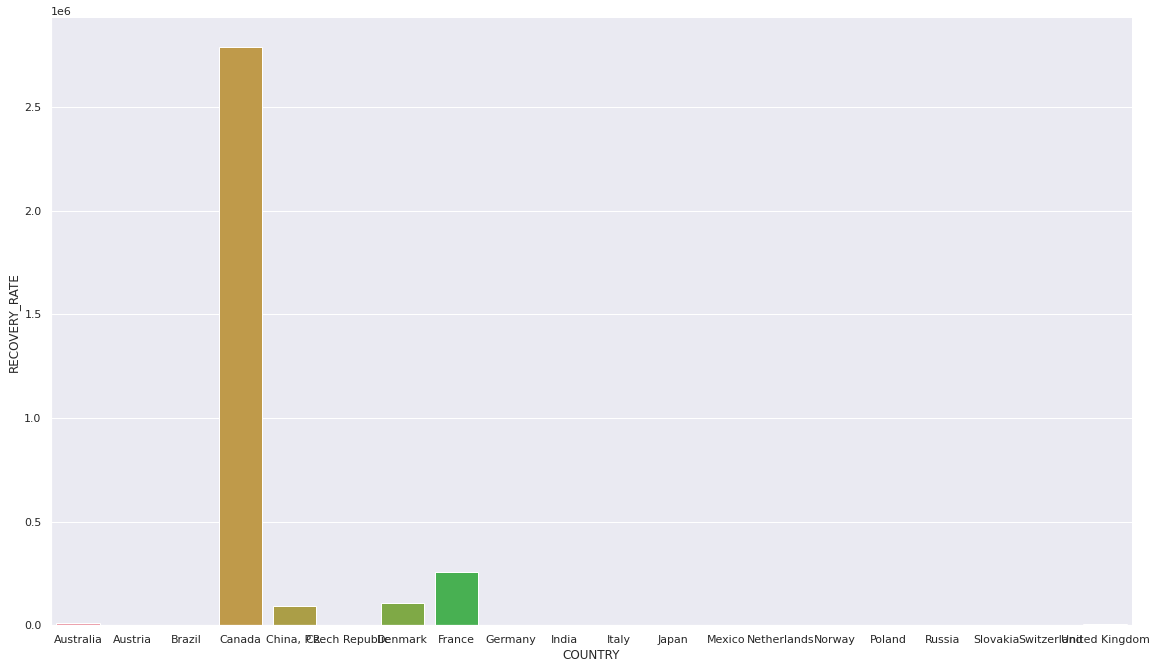

In [ ]:
h = sns.catplot(x="COUNTRY", y="RECOVERY_RATE", kind="bar", data=rate_df)
h.fig.set_figwidth(20)
h.fig.set_figheight(10)

###Countries with maximum no of bookings in 2020

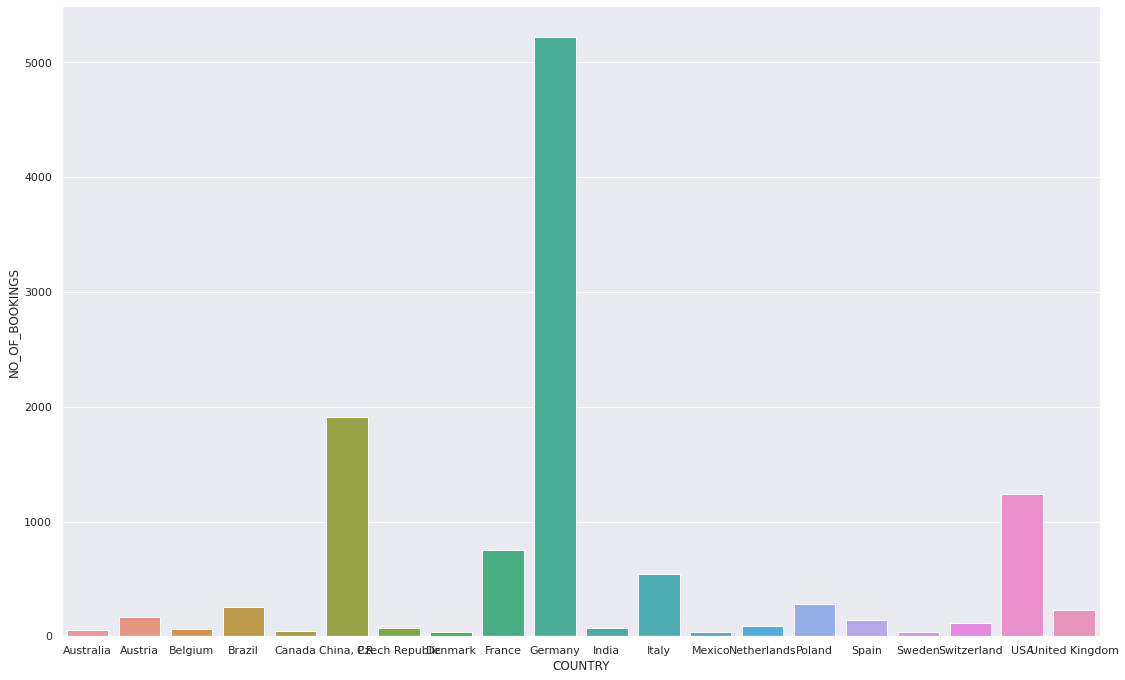

In [ ]:
g = sns.catplot(x="COUNTRY", y="NO_OF_BOOKINGS", kind="bar", data=book_df)
g.fig.set_figwidth(20)
g.fig.set_figheight(10)

In [ ]:
# import libraries
import folium
import pandas as pd
import pathlib
    
world = json.load(f)
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat':[61, 56, 51, 37, 43, 36, -28, -10, 40, 27],
'lon':[105, -106, 10, -95, 12, 138, 24, -53, -3, 80],
'name':['Russia ', 'Canada', 'Germany', 'USA', 'Italy', 'Japan', 'South Africa', 'Brazil', 'Spain', 'India']
})
data
 
# Make an empty map
m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(data)):
  folium.Marker([data.iloc[i]['lon'], data.iloc[i]['lat']], popup=data.iloc[i]['name']).add_to(m)
 
# Save it as html
m.save('312_markers_on_folium_map1.html')


# Random forest Prediction

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
count_df['COUNTRY'] = labelencoder.fit_transform(count_df['COUNTRY'])
count_df.head()

,COUNTRY,YEAR,MONTH,NO_OF_BOOKINGS,RECOVERY_RATE
0,0,2020,3,1,13
1,1,2020,1,2,0
2,1,2020,2,1,0
3,1,2020,3,1,5
4,2,2020,1,8,1


In [ ]:
# Labels are the values we want to predict
labels = np.array(count_df['NO_OF_BOOKINGS'])
features = count_df.drop('NO_OF_BOOKINGS', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (331, 4)
Training Labels Shape: (331,)
Testing Features Shape: (83, 4)
Testing Labels Shape: (83,)


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), ' bookings.')

Mean Absolute Error: 33.02  bookings.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: -205.82 %.


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: COUNTRY              Importance: 0.66
Variable: RECOVERY_RATE        Importance: 0.27
Variable: MONTH                Importance: 0.07
Variable: YEAR                 Importance: 0.0


In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('COUNTRY'), feature_list.index('RECOVERY_RATE')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), ' bookings.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 33.88  bookings.
Accuracy: -204.09 %.


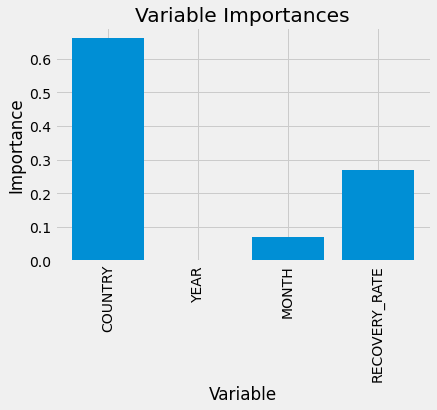

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

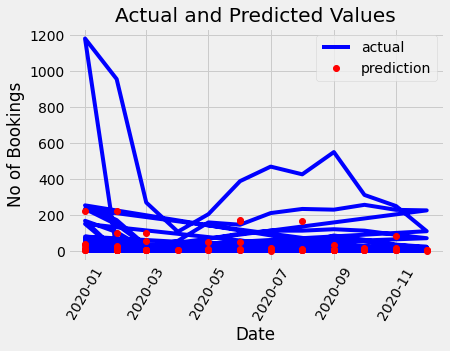

In [ ]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = features[:, feature_list.index('MONTH')]
years = features[:, feature_list.index('YEAR')]
# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) for year, month in zip(years, months)]
dates = [datetime.datetime.strptime(date, '%Y-%m') for date in dates]
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
# Dates of predictions
months = test_features[:, feature_list.index('MONTH')]
years = test_features[:, feature_list.index('YEAR')]
# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) for year, month in zip(years, months)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('No of Bookings'); plt.title('Actual and Predicted Values');